In [20]:
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from LowLevelModules.GeneralFunctions import *
import numpy as np
import time
from LowLevelModules.LakeShore import LakeShore335
from pymeasure.instruments.keithley import Keithley2400
# keithley stuff
keithley = Keithley2400("GPIB0::24::INSTR")   # 'ASRL9::INSTR' if RS232 connection
keithley.apply_current()                # Sets up to source voltage
keithley.source_current_range = .1      # Sets the source voltage range to 1 V
keithley.compliance_voltage = 1      # Sets the compliance current to 1 mA
keithley.source_current = 0    
keithley.measure_voltage()              # Sets up to measure voltage

#lakeshore stuff
lakeshore = LakeShore335('GPIB0::12::INSTR')
lakeshore.set_target_temperature(294)
lakeshore.turn_heater_off()

VisaIOError: VI_ERROR_NLISTENERS (-1073807265): No listeners condition is detected (both NRFD and NDAC are deasserted).

In [11]:
FS_LABEL = 20
FS_TICKS = 18
class LivePlot2Vert:
    def __init__(self, x_ext=12, y_ext=6, mk='o', xlabel1='x1', ylabel1='y1', xlabel2='x2', ylabel2='y2'):
        self.fig = plt.figure(figsize=(x_ext, y_ext))
        self.ax1 = self.fig.add_subplot(211)
        plt.plot([], [], marker=mk)
        plt.xlabel(xlabel1, labelpad=10, fontsize=FS_LABEL)
        plt.ylabel(ylabel1, labelpad=10, fontsize=FS_LABEL)
        self.ax1.tick_params(axis='both', labelsize=FS_TICKS)

        self.ax2 = self.fig.add_subplot(212)
        plt.plot([], [], marker=mk)
        plt.xlabel(xlabel2, labelpad=10, fontsize=FS_LABEL)
        plt.ylabel(ylabel2, labelpad=10, fontsize=FS_LABEL)
        self.ax2.tick_params(axis='both', labelsize=FS_TICKS)

        self.fig.show()
        self.fig.canvas.draw()
        plt.tight_layout()

    def plot_live(self, xdata1, ydata1, xdata2, ydata2):
        self.ax1.lines[0].set_xdata(xdata1)
        self.ax1.lines[0].set_ydata(ydata1)
        self.ax1.relim()
        self.ax1.autoscale_view()

        self.ax2.lines[0].set_xdata(xdata2)
        self.ax2.lines[0].set_ydata(ydata2)
        self.ax2.relim()
        self.ax2.autoscale_view()

        self.fig.canvas.draw()
        plt.pause(1e-7)

<IPython.core.display.Javascript object>


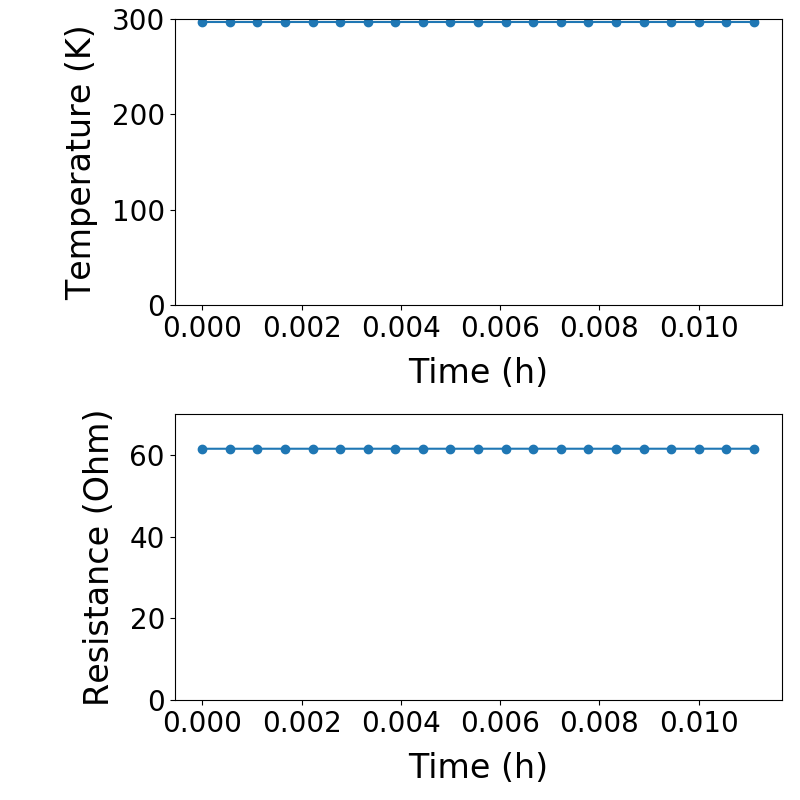

In [15]:
"""#######################################   USER INPUT   #################################################"""
save_data = False
collection_time = 2  #seconds

"""#########################################################################################################"""

# initialize the rest
lp = LivePlot2Vert(8, 8, 'o', 'Time (h)', 'Temperature (K)', 'Time (h)', 'Resistance (Ohm)')
lp.ax1.set_ylim([0, 300])
lp.ax2.set_ylim([0, 70])
ti, Ta, Rs = [], [], []
t_now = 0

keithley.enable_source()
A = 0.01
keithley.ramp_to_current(A)                

while True:
    try:
        ti.append(t_now/3600)
        #measure the resistance
        Rs.append(keithley.voltage / A) 
        #measure the temperature
        Ta.append(lakeshore.get_temp("A"))
        print("T= "+ str(lakeshore.get_temp("A")) + " K.    R = ", keithley.voltage / A, end="\r")
        lp.plot_live(ti, Ta, ti, Rs)
        time.sleep(collection_time)
        t_now += collection_time
        #lp.ax1.legend(['Shield', 'Sample'], fontsize=20)

    except KeyboardInterrupt:
        break

keithley.disable_source()               

plt.show()
if save_data:
    data_type = 'Cryostat'
    data_header = "Time (hour)               Temp (K)                   Resistance (Ohm)"
    data_array = np.array([ti, Ta, Rs]).T
    data_save(data_array, lp.fig, data_type, data_header)
    

In [16]:
keithley.shutdown()    

<IPython.core.display.Javascript object>


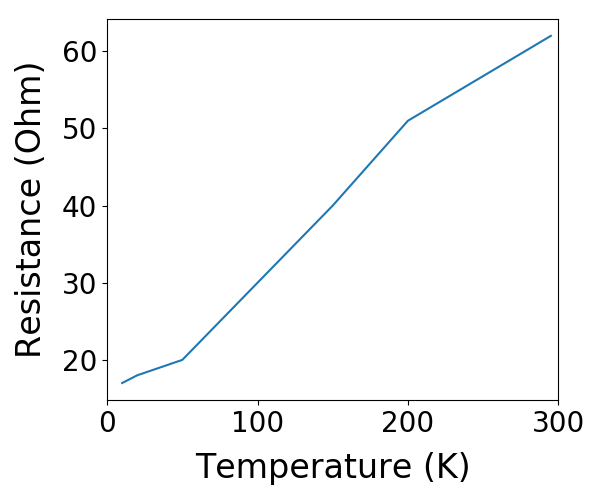

In [19]:
Temp = [10, 20, 50, 100, 150, 200, 295]
Res = [17, 18, 20, 30, 40 ,51, 62]
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(Temp, Res)
prettify_plot(ax, "Temperature (K)", "Resistance (Ohm)")
ax.set_xlim([0, 300])
plt.tight_layout()